# Finding the ohmic regime 

Identifying the $(\kappa,\,\omega_0,\Delta\mu)$ values for wich $I\propto\Delta\mu$ (i.e. ohmic regime) at all $T$

## **Step 1:** Import relevant packages and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensor_linregress import tensor_linregress
from param_parser import ParameterParser
import plt_utils

#plt_utils.setup_tex()
rcParams['image.aspect'] = 'auto'

kB = 8.617e-5
#temp_grid = np.linspace(40,4000,200)

#npydir = 'MAC_full_misaligned'
#param_file = 'original_params.json'

npydir = 'MAC_aligned_focused_max_dmu0.02_no_shift'
param_file = 'aligned_focused_max_dmu0.02.json'

pp = ParameterParser(param_file)

kappa_grid, w0_grid, muL_grid, temp_grid, e_grid = \
pp.load_grids(plist=['kappa_grid', 'frequency_grid','muL_grid',\
    'temperature_grid', 'energy_grid'])

dmu_grid = muL_grid * 2

I = np.moveaxis(np.load('%s/current_dis.npy'%npydir),2,-1) #move dmu axis to last position to use tensor_linregress painlessly
# axes of I are now: (w0, kappa, T, dmu)

# **Step 2:** Perform linear fit; plot best and worst fits

The best fit corresponds to the most ohmic conditions. The worst fit is the least ohmic.
This gives us an idea of what we're dealing with; what range of behaviours do the parameters specified in `param_file` allow?

0.9999999969936744
Best fit r^2 =  0.9999999969936744
Best fit indices =  (0, 6, 390)
Worst fit r^2 =  0.42547510115120457
Worst fit indices =  (20, 10, 0)


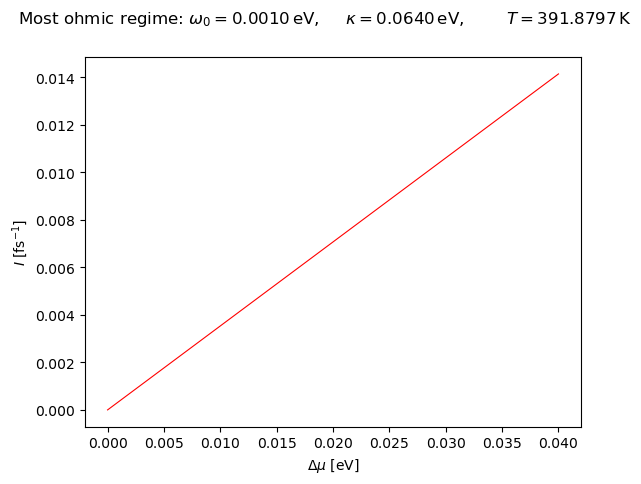

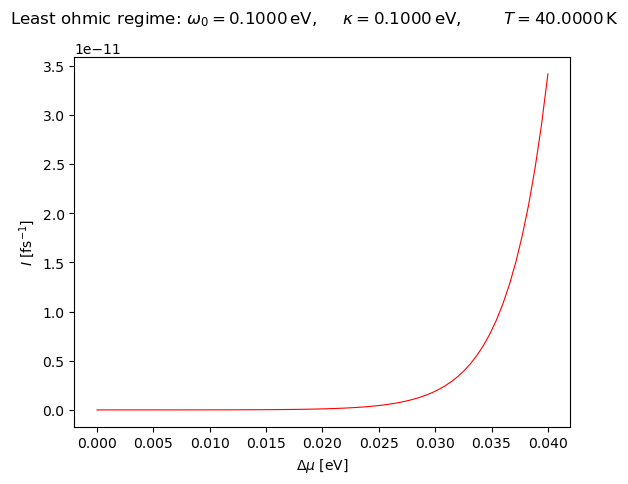

In [2]:
*_, rvals = tensor_linregress(dmu_grid, I)
print(np.max(rvals**2))

most_ohmic_inds = np.unravel_index((rvals**2).argmax(),rvals.shape)
least_ohmic_inds = np.unravel_index((rvals**2).argmin(),rvals.shape)

print('Best fit r^2 = ',np.max(rvals**2))
print('Best fit indices = ', most_ohmic_inds)

print('Worst fit r^2 = ',np.min(rvals**2))
print('Worst fit indices = ', least_ohmic_inds)

plt.plot(dmu_grid,I[most_ohmic_inds],'r-',lw=0.8)
plt.suptitle(f'Most ohmic regime: $\omega_0 = {w0_grid[most_ohmic_inds[0]]:6.4f}\,$eV,\
     $\kappa = {kappa_grid[most_ohmic_inds[1]]:6.4f}\,$eV,\
        $T={temp_grid[most_ohmic_inds[2]]:6.4f}\,$K')
plt.xlabel('$\Delta\mu$ [eV]')
plt.ylabel('$I$ [fs$^{-1}$]')
plt.show()

plt.plot(dmu_grid,I[least_ohmic_inds],'r-',lw=0.8)
plt.suptitle(f'Least ohmic regime: $\omega_0 = {w0_grid[least_ohmic_inds[0]]:6.4f}\,$eV,\
     $\kappa = {kappa_grid[least_ohmic_inds[1]]:6.4f}\,$eV,\
        $T={temp_grid[least_ohmic_inds[2]]:6.4f}\,$K')
plt.xlabel('$\Delta\mu$ [eV]')
plt.ylabel('$I$ [fs$^{-1}$]')
plt.show()


## Sidequest: Find values of $(\omega_0,\kappa)$ where $I\propto\Delta\mu$ for all $\Delta\mu$ and all $T$
Not super important; mainly for curiosity's sake: are there parameter combinations for which the current-voltage remains linear at all voltages and temperature.

Ohmic for all V for 0 of 231 possible parameter combinations.


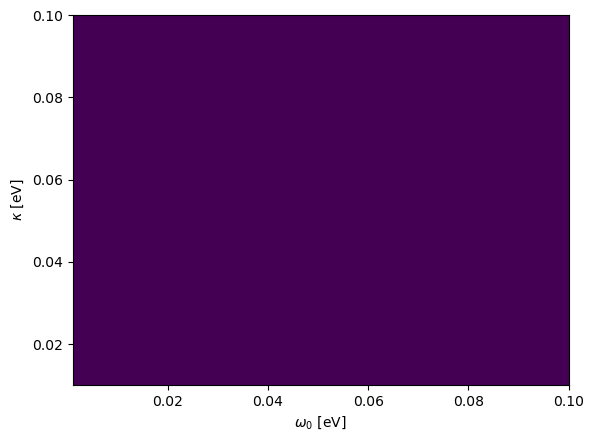

In [3]:
# ohm_bools will be True where I ~ V for all values of V for specific values of (w0,kappa,beta)
ohm_bools = (rvals**2 > 0.985)
# Obtain (w0, kappa) values for which ohmic regime is maintained at all temperatures
ohm_bools_allT = np.all(ohm_bools, axis=2)
print('Ohmic for all V for %d of %d possible parameter combinations.'%(np.sum(ohm_bools_allT), ohm_bools_allT.size))
plt.imshow(ohm_bools_allT.T,origin='lower', extent=[*w0_grid[[0,-1]], *kappa_grid[[0,-1]]])
plt.xlabel('$\omega_0$ [eV]')
plt.ylabel('$\kappa$ [eV]')
plt.show()

## ***IMPORTANT PART STARTS HERE***

## **Step 3:** Identify max $\Delta\mu$ for which $I\propto\Delta\mu$ for all $(\omega_0,\,\kappa,\,T)$
Now we do this for real: what is the maximum bias that can sustain a linear $I$-$V$ relationship for all other conditions considered.

### ***Step 3a:*** $r^2$ test
Determine whether the $I$-$V$ curve is ohmic based on the quality of the linear fit.
We deem: $r^2 > 0.99\implies$ ohmic regime.

In [4]:
# We focus only on postive bias (ie V > 0).

pos_inds = (dmu_grid > 0).nonzero()[0]
dmu_grid = dmu_grid[pos_inds]
I = I[:,:,:,pos_inds]

all_ohmic = True
dmu_ind = 2

while all_ohmic and (dmu_ind < dmu_grid.size):
    print('\n')
    *_, rvals = tensor_linregress(dmu_grid[:dmu_ind],I[:,:,:,:dmu_ind])
    ohm_bools = (rvals**2 >= 0.985)
    print('Worst linear fit rval = ', np.min(rvals))
    minds = np.unravel_index(np.argmin(rvals), rvals.shape)
    print('Worst fit inds: ', minds)
    maxinds = np.unravel_index(np.argmax(rvals), rvals.shape)
    print('Best linear fit rval = ', np.max(rvals))
    print('Best fit inds: ', maxinds)
    print('Number of ohmic realisations for dmu <= %5.3f = '%dmu_grid[dmu_ind-1], np.sum(ohm_bools))

    all_ohmic = np.all(ohm_bools)
    dmu_ind += 1

print(dmu_ind)
print('Max dmu value = ', dmu_grid[dmu_ind-2])

print(dmu_grid[:dmu_ind-1])



Worst linear fit rval =  0.9999999999999968
Worst fit inds:  (14, 2, 6)
Best linear fit rval =  1.0000000000000029
Best fit inds:  (1, 3, 20)
Number of ohmic realisations for dmu <= 0.001 =  92400


Worst linear fit rval =  0.9996689414993253
Worst fit inds:  (8, 10, 0)
Best linear fit rval =  1.0000000000000007
Best fit inds:  (0, 6, 360)
Number of ohmic realisations for dmu <= 0.002 =  92400


Worst linear fit rval =  0.9991668701770381
Worst fit inds:  (8, 10, 0)
Best linear fit rval =  0.9999999999998922
Best fit inds:  (0, 6, 367)
Number of ohmic realisations for dmu <= 0.002 =  92400


Worst linear fit rval =  0.9984742794309028
Worst fit inds:  (9, 10, 0)
Best linear fit rval =  0.9999999999997132
Best fit inds:  (0, 0, 373)
Number of ohmic realisations for dmu <= 0.003 =  92400


Worst linear fit rval =  0.9974828775539794
Worst fit inds:  (9, 10, 0)
Best linear fit rval =  0.9999999999994738
Best fit inds:  (0, 4, 376)
Number of ohmic realisations for dmu <= 0.003 =  92400



## ***Step 3b:*** Slope test
We check fo the same thing as in step 3a, but this time, we consider the $I$-$V$ curve to be ohmic over a certain range of $\Delta\mu$ if $I(\Delta\mu)/\Delta\mu$ remains roughly the same (up to some tunable tolerance parameter) for all values of $\Delta\mu$ in that range.
We of course assume that $I(\Delta\mu = 0) = 0$ (i.e. no current at zero bias). Could in principle write code without making this assumption. We compare values of $I(\Delta\mu = 0)$ and $I(\Delta\mu>0)$ in another Jupyter notebook.

Note that we are not taking the derivative $\frac{\partial I}{\partial\{\Delta\mu\}}$. The idea is that, in the linear regime,
this derovative is constant. Assuming the linear regime holds for $\Delta\mu\rightarrow 0$ eV, then the only relevant slope is: $$\frac{I(\Delta\mu) - I(\Delta\mu=0)}{\Delta\mu}$$.

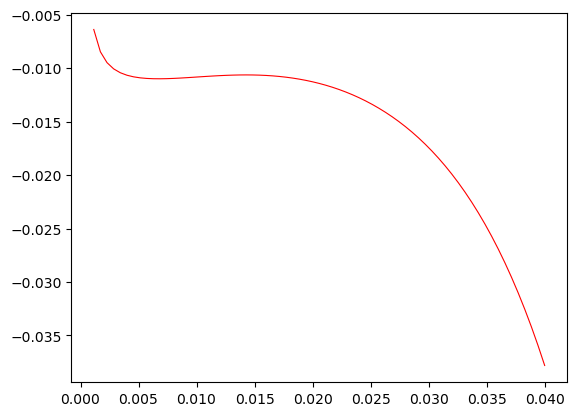

In [6]:
I_zero_bias = I[:,:,:,0]
I_finite_bias = I[:,:,:,1:]

# Slopes of I-V curve
slopes = (I_finite_bias - I_zero_bias[:,:,:,None])/dmu_grid[None,None,None,1:]

deriv2 = (slopes[1:] - slopes[:-1]) / (dmu_grid[1:] - dmu_grid[:-1])

eps_slope = 1e-10 #tolerance of deviations

tcm = plt_utils.get_cm(temp_grid,'coolwarm',max_val=1.0)
dmucm = plt_utils.get_cm(temp_grid,'inferno')
w0cm = plt_utils.get_cm(w0_grid,'plasma')
kcm = plt_utils.get_cm(kappa_grid,'viridis')


